## Kaggle Competition:Histopathologic Cancer Detection
Author: Sara Rhoades
Class: CSPB 3202

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #plotting
import matplotlib.image as mpimg #image loading
import cv2 #image loading
import os

import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import sklearn.linear_model as lm
import sklearn.neighbors as knn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

## Problem Description

Cancer detection uses machine learning algorithms to identify metastatic cancer in small image patches taken from larger digital pathology scans  [ref 1]. By correctly classifying images and positive or negative for cancer, better diagnostics can be created for medical scanning. These images are not obvious as to which classification should be applied or to which features are important for classification.

## Data Description
220,025 samples of labeled images are provided for classifier training and another 57,458 images are reserved for test data. All images are tif files with a rectangular grid of 96x96 pixels in an RGB (three color) format. Note that it is not obvious to the untrained eye which of the images belong to each class.

In [2]:
training_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)
print(training_labels.shape)
training_labels.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


A random sampling of the training data is provided below, showing 16 examples of the images with labels as to cancerous (class 1) or non-cancerous (class 0) [ref 2].

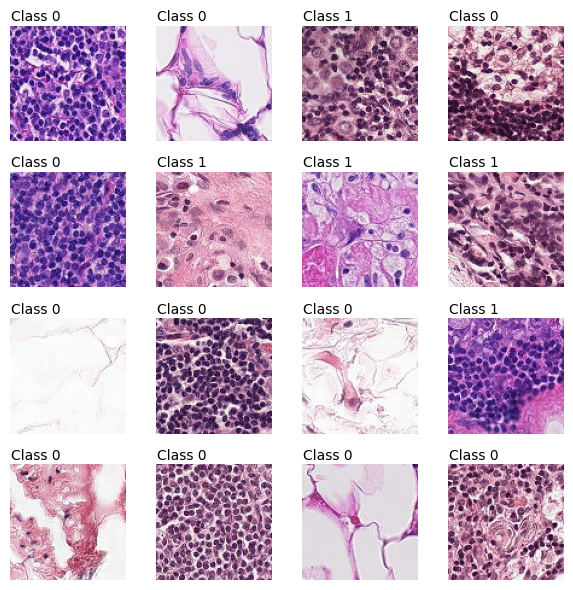

In [3]:
plt.figure(figsize=(6,6))
sample = training_labels.sample(n=16).reset_index()

for i, row in sample.iterrows():

    img = mpimg.imread(f'../input/histopathologic-cancer-detection/train/{row.id}.tif')    
    label = row.label

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
        
    plt.axis('off')

plt.tight_layout()
plt.show()

The test data is the same format as the training data, except it does not have a classification label.

Image Metadata:
Shape: (96, 96, 3)


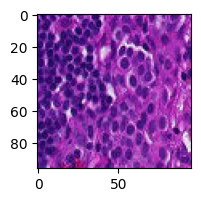

In [4]:
example_test_image = mpimg.imread(f'../input/histopathologic-cancer-detection/test/000360e0d8358db520b5c7564ac70c5706a0beb0.tif')
plt.figure(figsize=(2,2))
plt.imshow(example_test_image)
print("Image Metadata:\nShape:",example_test_image.shape,)

## EDA and Data Cleaning
This is a binary classification problem, with only a positive (1) or negative (0) labeling of the images. Data sets which are too imbalanced between the categories can have trouble with predictions and need proccessing methods to create a more balanced set of training data.

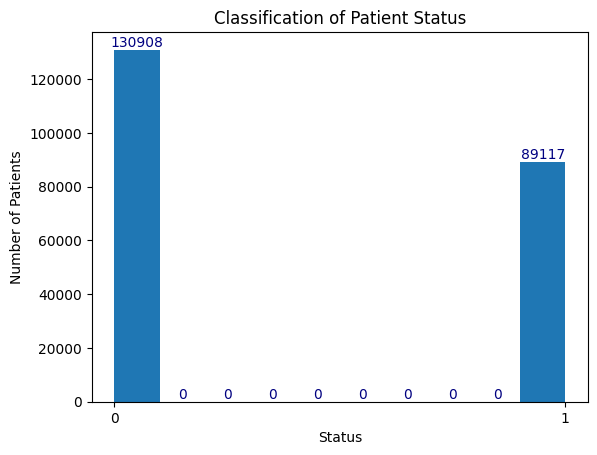

In [5]:
plt.figure()
values, bins, bars = plt.hist(training_labels.label)
plt.title("Classification of Patient Status")
plt.xlabel("Status")
plt.ylabel("Number of Patients")
plt.bar_label(bars, fontsize=10, color='navy')
plt.show()

From an exploratory look at the data, no missing values are found. While not quite a 50-50 split, there is not a drastic imbalance between the two classifications in the data; no resampling methods are required in order to get a more even split between the categories.

In [6]:
print("Number of Invalid Entries:\n",training_labels.isnull().sum(),"\n")
print("Number of Entries of each type\n",(training_labels.groupby(['label']))["label"].count(),"\n")

Number of Invalid Entries:
 id       0
label    0
dtype: int64 

Number of Entries of each type
 label
0    130908
1     89117
Name: label, dtype: int64 



Functions were created for data loading, cleaning, and feature extraction based on prior submissions of this data (ref 3 and ref 4), as well as of exploratory data analysis later in this report.

In [7]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    # if we have labels for this data, also get them
    if 'label' in df.columns:
        y = df['label'].to_numpy()[0:N]
    else:
        y = None
    #read images one by one
    sample = training_labels.sample(n=N).reset_index()
    for i, row in sample.iterrows():
        if i == N:
            break
        X[i] = cv2.imread(f'../input/histopathologic-cancer-detection/train/{row.id}.tif')
          
    return X,y

# Load 10k training images
N=10000
training_data = pd.DataFrame({'id': training_labels.id, 'label': training_labels.label})
training_data_images, training_data_labels = load_data(N=N,df=training_data)

Before training a model in classification predictions, an exploratory data anysis was performed in order to determining which features to use. Training data is separated into two sets, one with a positive label and ones with a negative label. This is done to see if there are any visual differences that can be seen in the features of these two data sets; anything that can be distinguished is a candidate as as good predition feature. 

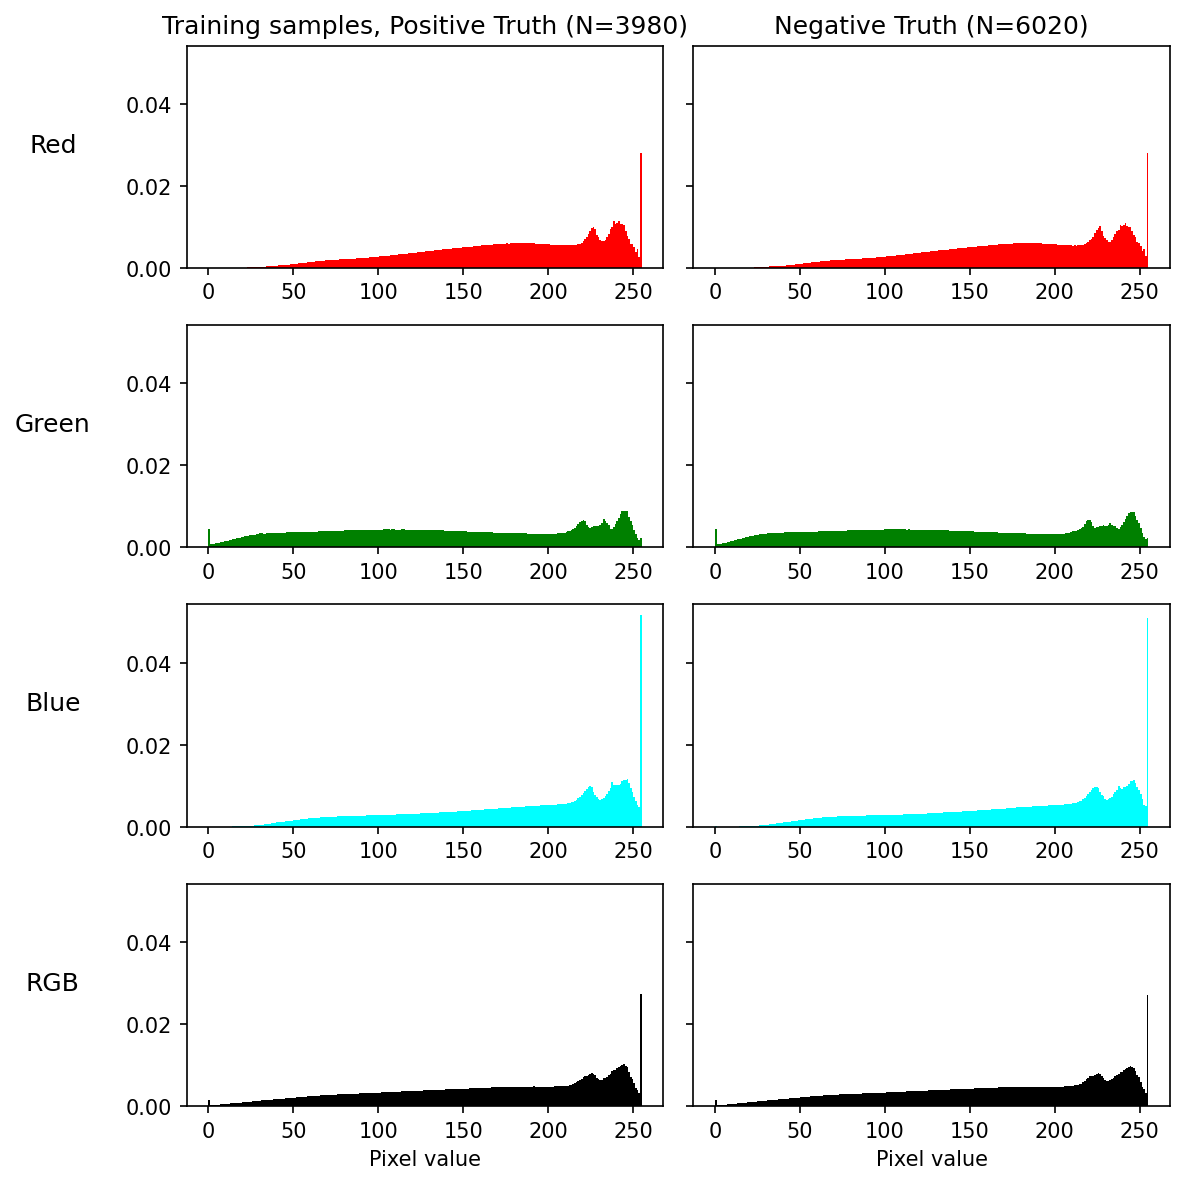

In [8]:
# EDA
positive_data_images = training_data_images[(training_data_labels=='1').ravel()]
negative_data_images = training_data_images[(training_data_labels=='0').ravel()]

nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_data_images[0:N,:,:,0].flatten(),bins=nr_of_bins,density=True,color='red')
axs[0,1].hist(negative_data_images[0:N,:,:,0].flatten(),bins=nr_of_bins,density=True,color='red')

axs[1,0].hist(positive_data_images[0:N,:,:,1].flatten(),bins=nr_of_bins,density=True,color='green')
axs[1,1].hist(negative_data_images[0:N,:,:,1].flatten(),bins=nr_of_bins,density=True,color='green')

axs[2,0].hist(positive_data_images[0:N,:,:,2].flatten(),bins=nr_of_bins,density=True,color='cyan')
axs[2,1].hist(negative_data_images[0:N,:,:,2].flatten(),bins=nr_of_bins,density=True,color='cyan')

#All channels
axs[3,0].hist(positive_data_images[0:N].flatten(),bins=nr_of_bins,density=True,color='black')
axs[3,1].hist(negative_data_images[0:N].flatten(),bins=nr_of_bins,density=True,color='black')

#Set image labels
axs[0,0].set_title("Training samples, Positive Truth (N=" + str(positive_data_images.shape[0]) + ")");
axs[0,1].set_title("Negative Truth (N=" + str(negative_data_images.shape[0]) + ")");

axs[0,0].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,0].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,0].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,0].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)

axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

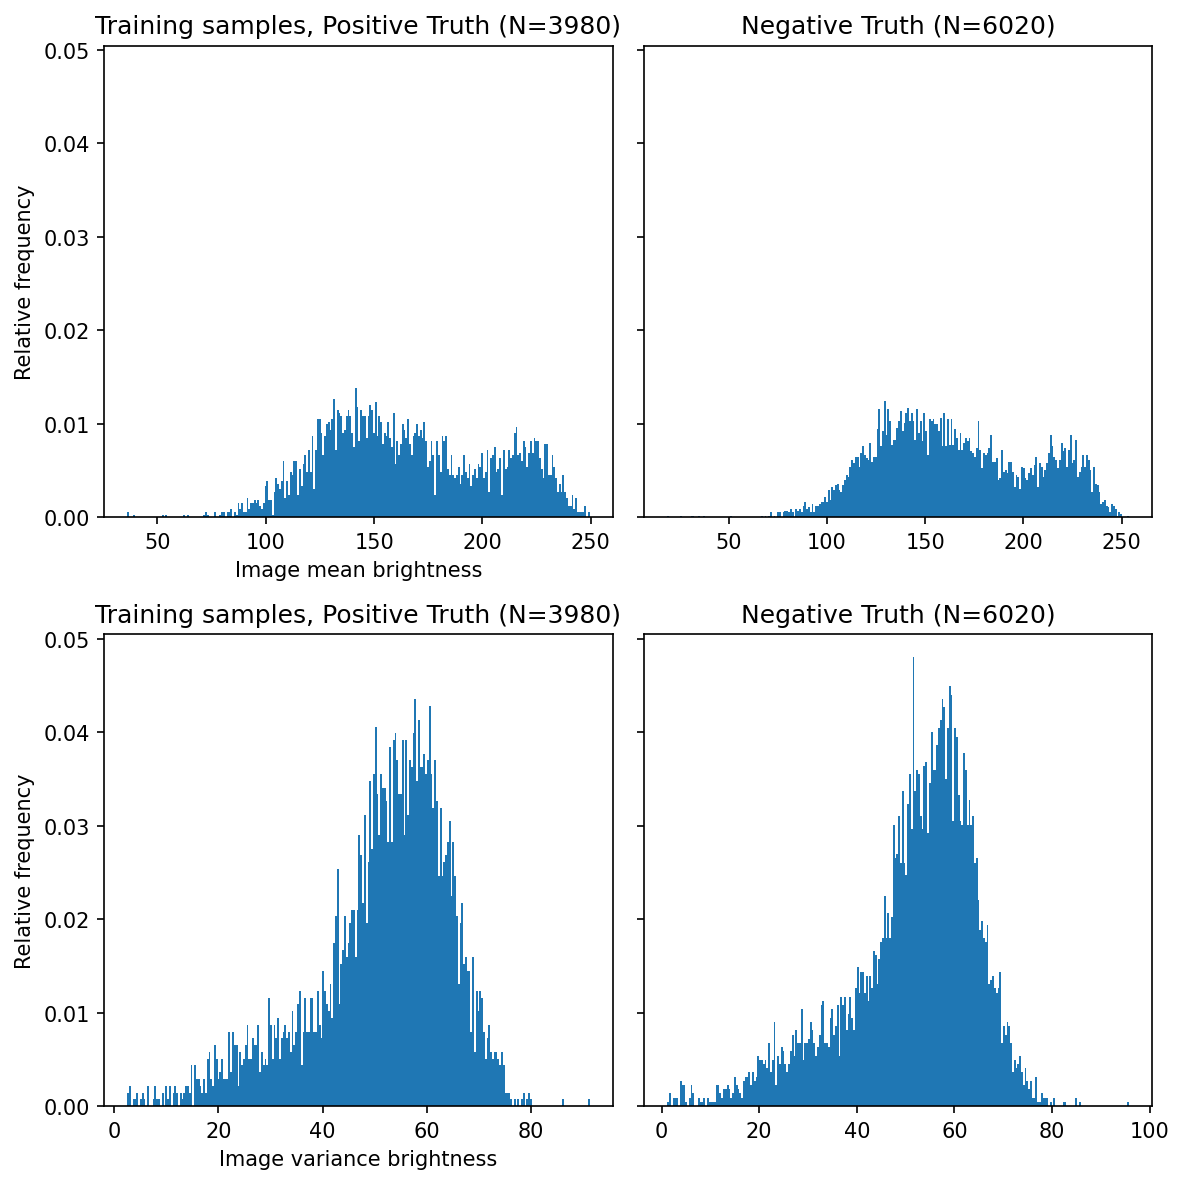

In [9]:
# Brightness
fig,axs = plt.subplots(2,2,sharey=True,figsize=(8,8),dpi=150)
axs[0,0].hist(np.mean(positive_data_images,axis=(1,2,3))[0:N],bins=nr_of_bins,density=True)
axs[0,1].hist(np.mean(negative_data_images,axis=(1,2,3))[0:N],bins=nr_of_bins,density=True)
axs[1,0].hist(np.std(positive_data_images,axis=(1,2,3))[0:N],bins=nr_of_bins,density=True)
axs[1,1].hist(np.std(negative_data_images,axis=(1,2,3))[0:N],bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Training samples, Positive Truth (N=" + str(positive_data_images.shape[0]) + ")");
axs[0,1].set_title("Negative Truth (N=" + str(negative_data_images.shape[0]) + ")");
axs[0,0].set_xlabel("Image mean brightness")
axs[0,0].set_ylabel("Relative frequency")

axs[1,0].set_title("Training samples, Positive Truth (N=" + str(positive_data_images.shape[0]) + ")");
axs[1,1].set_title("Negative Truth (N=" + str(negative_data_images.shape[0]) + ")");
axs[1,0].set_xlabel("Image variance brightness")
axs[1,0].set_ylabel("Relative frequency")
fig.tight_layout()

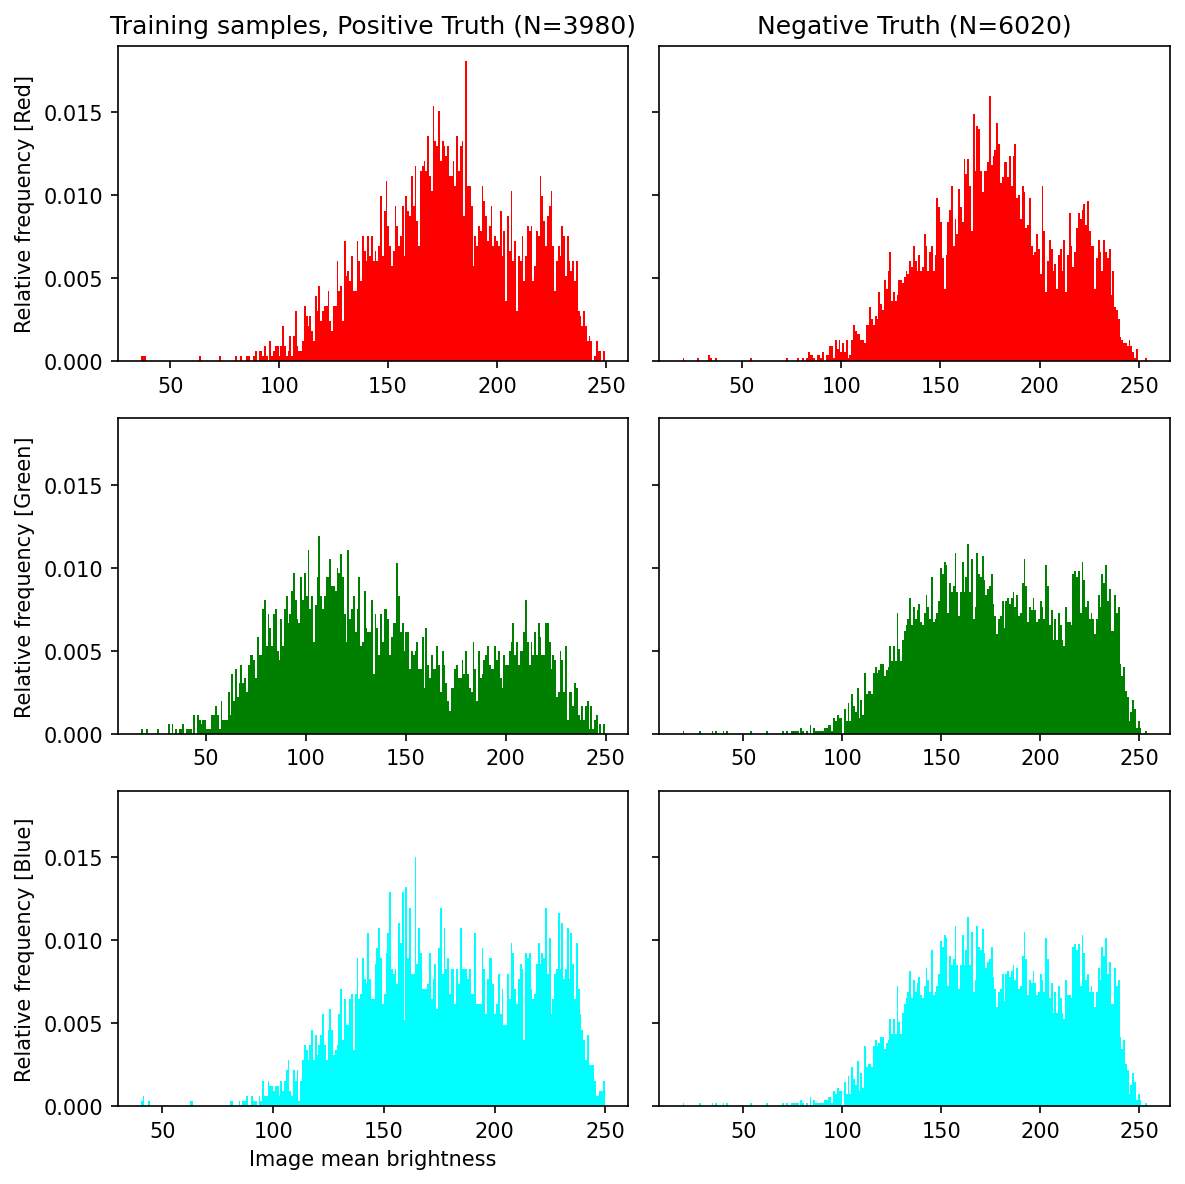

In [10]:
# Color Brightness (Mean)
fig,axs = plt.subplots(3,2,sharey=True,figsize=(8,8),dpi=150)
axs[0,0].hist(np.mean(positive_data_images,axis=(1,2))[0:N,0],bins=nr_of_bins,density=True,color='red')
axs[0,1].hist(np.mean(negative_data_images,axis=(1,2))[0:N,0],bins=nr_of_bins,density=True,color='red')

axs[1,0].hist(np.mean(positive_data_images,axis=(1,2))[0:N,1],bins=nr_of_bins,density=True,color='green')
axs[1,1].hist(np.mean(negative_data_images,axis=(1,2))[0:N,2],bins=nr_of_bins,density=True,color='green')

axs[2,0].hist(np.mean(positive_data_images,axis=(1,2))[0:N,2],bins=nr_of_bins,density=True,color='cyan')
axs[2,1].hist(np.mean(negative_data_images,axis=(1,2))[0:N,2],bins=nr_of_bins,density=True,color='cyan')

#Set image labels
axs[0,0].set_title("Training samples, Positive Truth (N=" + str(positive_data_images.shape[0]) + ")");
axs[0,1].set_title("Negative Truth (N=" + str(negative_data_images.shape[0]) + ")");
axs[2,0].set_xlabel("Image mean brightness")
axs[0,0].set_ylabel("Relative frequency [Red]")
axs[1,0].set_ylabel("Relative frequency [Green]")
axs[2,0].set_ylabel("Relative frequency [Blue]")
fig.tight_layout()

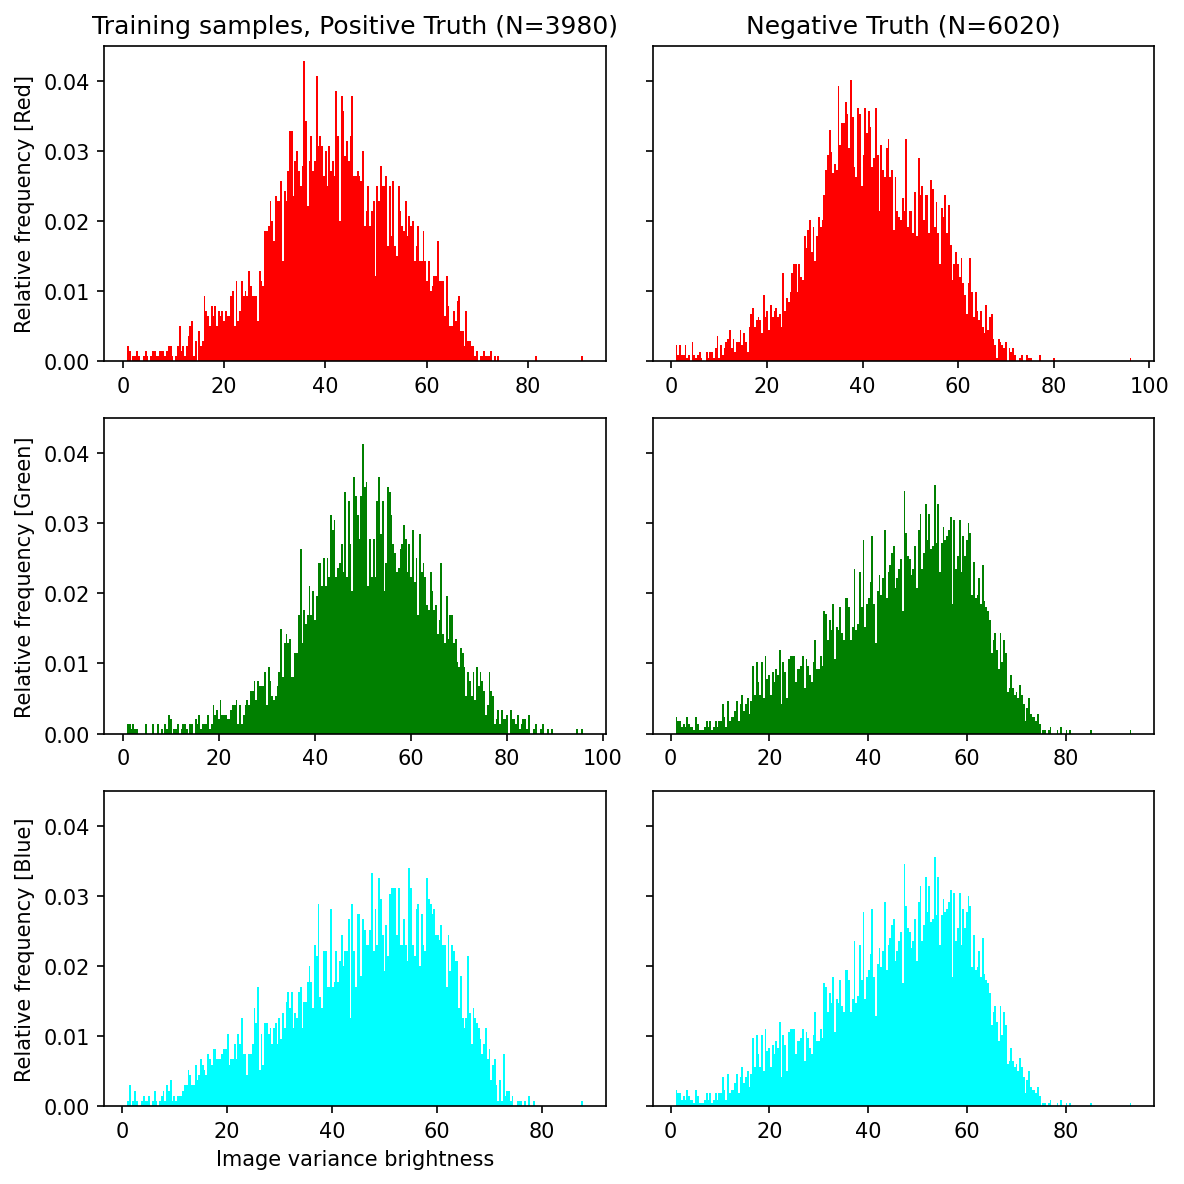

In [11]:
# Color Brightness (Variance)
fig,axs = plt.subplots(3,2,sharey=True,figsize=(8,8),dpi=150)
axs[0,0].hist(np.std(positive_data_images,axis=(1,2))[0:N,0],bins=nr_of_bins,density=True,color='red')
axs[0,1].hist(np.std(negative_data_images,axis=(1,2))[0:N,0],bins=nr_of_bins,density=True,color='red')

axs[1,0].hist(np.std(positive_data_images,axis=(1,2))[0:N,1],bins=nr_of_bins,density=True,color='green')
axs[1,1].hist(np.std(negative_data_images,axis=(1,2))[0:N,2],bins=nr_of_bins,density=True,color='green')

axs[2,0].hist(np.std(positive_data_images,axis=(1,2))[0:N,2],bins=nr_of_bins,density=True,color='cyan')
axs[2,1].hist(np.std(negative_data_images,axis=(1,2))[0:N,2],bins=nr_of_bins,density=True,color='cyan')

#Set image labels
axs[0,0].set_title("Training samples, Positive Truth (N=" + str(positive_data_images.shape[0]) + ")");
axs[0,1].set_title("Negative Truth (N=" + str(negative_data_images.shape[0]) + ")");
axs[2,0].set_xlabel("Image variance brightness")
axs[0,0].set_ylabel("Relative frequency [Red]")
axs[1,0].set_ylabel("Relative frequency [Green]")
axs[2,0].set_ylabel("Relative frequency [Blue]")
fig.tight_layout()

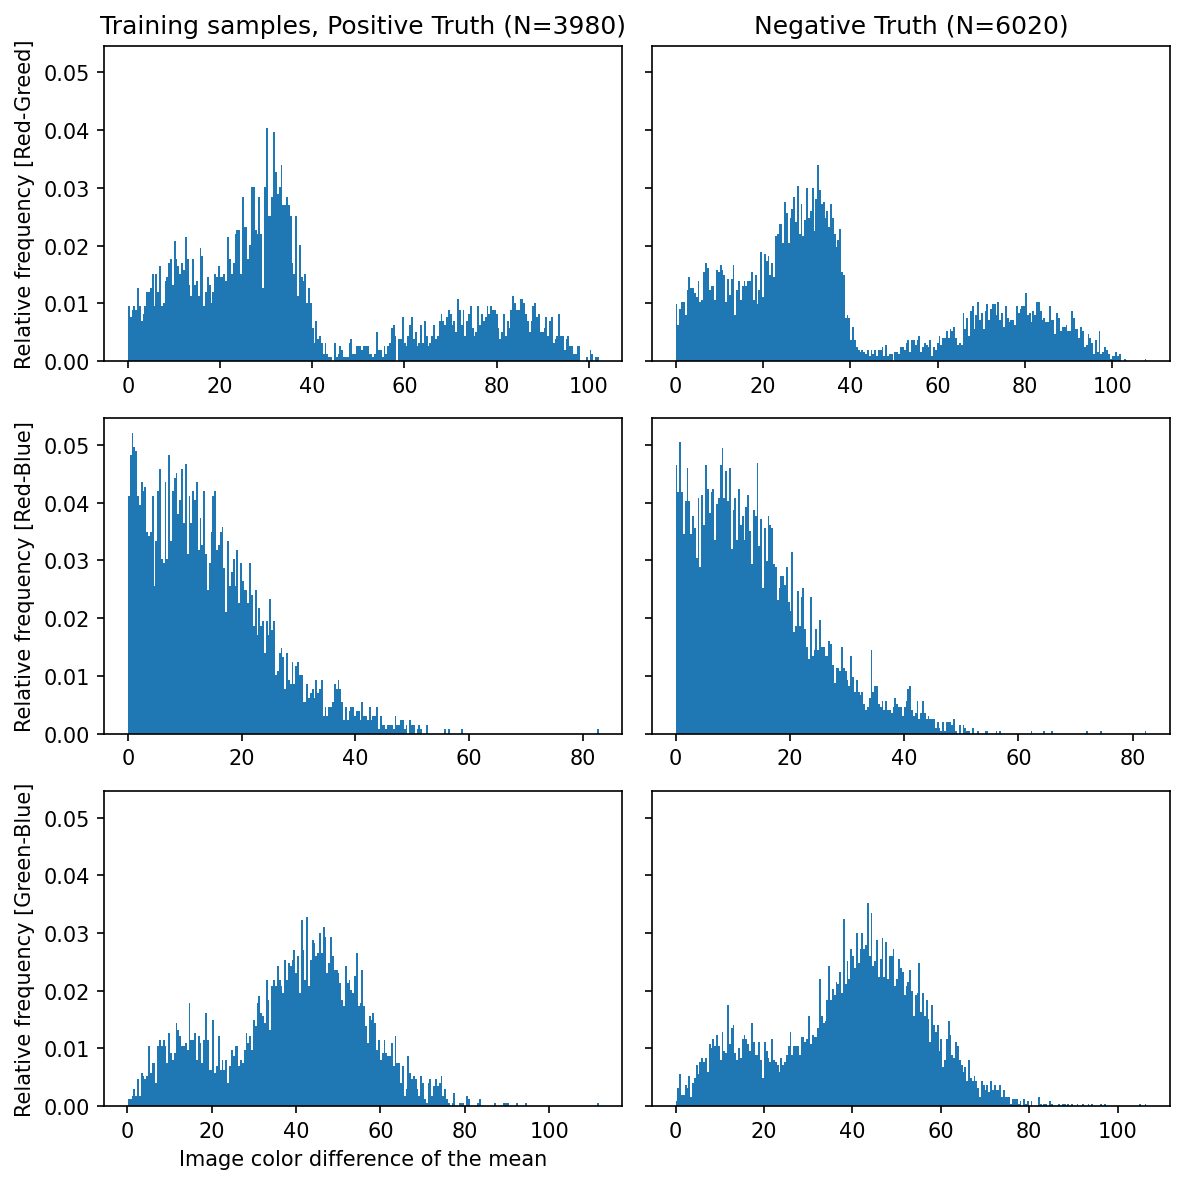

In [12]:
# Color Difference of the Mean
deltaRGPos = np.abs(np.mean(positive_data_images,axis=(1,2))[0:N,0]-np.mean(positive_data_images,axis=(1,2))[0:N,1])
deltaRBPos = np.abs(np.mean(positive_data_images,axis=(1,2))[0:N,0]-np.mean(positive_data_images,axis=(1,2))[0:N,2])
deltaGBPos = np.abs(np.mean(positive_data_images,axis=(1,2))[0:N,1]-np.mean(positive_data_images,axis=(1,2))[0:N,2])
    
deltaRGNeg = np.abs(np.mean(negative_data_images,axis=(1,2))[0:N,0]-np.mean(negative_data_images,axis=(1,2))[0:N,1])
deltaRBNeg = np.abs(np.mean(negative_data_images,axis=(1,2))[0:N,0]-np.mean(negative_data_images,axis=(1,2))[0:N,2])
deltaGBNeg = np.abs(np.mean(negative_data_images,axis=(1,2))[0:N,1]-np.mean(negative_data_images,axis=(1,2))[0:N,2])
    
fig,axs = plt.subplots(3,2,sharey=True,figsize=(8,8),dpi=150)
axs[0,0].hist(deltaRGPos,bins=nr_of_bins,density=True)
axs[0,1].hist(deltaRGNeg,bins=nr_of_bins,density=True)

axs[1,0].hist(deltaRBPos,bins=nr_of_bins,density=True)
axs[1,1].hist(deltaRBNeg,bins=nr_of_bins,density=True)

axs[2,0].hist(deltaGBPos,bins=nr_of_bins,density=True)
axs[2,1].hist(deltaGBNeg,bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Training samples, Positive Truth (N=" + str(positive_data_images.shape[0]) + ")");
axs[0,1].set_title("Negative Truth (N=" + str(negative_data_images.shape[0]) + ")");
axs[2,0].set_xlabel("Image color difference of the mean")
axs[0,0].set_ylabel("Relative frequency [Red-Greed]")
axs[1,0].set_ylabel("Relative frequency [Red-Blue]")
axs[2,0].set_ylabel("Relative frequency [Green-Blue]")
fig.tight_layout()

In addition to exploratory analysis, data cleaning was also performed

In [13]:
def clean_data(df):
    return df

clean_training_data = clean_data(training_data_images)

Of the features above that were visualized, the ones with the most obvious differences between the categories are the mean and variance of the green color channel, the variance of the blue color channel, the difference in the mean between red and blue, and the overall variance of all colors. As the majority of visualy distince features are variances, the variance of the red channel was also included for completeness.

In [14]:
def extract_features(N,df):
    meanBrightness = np.mean(df,axis=(1,2,3))
    varBrightness = np.std(df,axis=(1,2,3))
    meanRGBBrightness = np.mean(df,axis=(1,2))
    varRGBBrightness = np.std(df,axis=(1,2))
    deltaRG = np.abs(meanRGBBrightness[0:N,0]-meanRGBBrightness[0:N,1])
    deltaRB = np.abs(meanRGBBrightness[0:N,0]-meanRGBBrightness[0:N,2])
    deltaGB = np.abs(meanRGBBrightness[0:N,1]-meanRGBBrightness[0:N,2])
    training_features = np.column_stack((
        #meanBrightness[0:N].reshape(N,), 
        varBrightness[0:N].reshape(N,), 
        #meanRGBBrightness[0:N,0].reshape(N,), 
        #meanRGBBrightness[0:N,1].reshape(N,), 
        #meanRGBBrightness[0:N,2].reshape(N,),
        varRGBBrightness[0:N,0].reshape(N,), 
        varRGBBrightness[0:N,1].reshape(N,), 
        varRGBBrightness[0:N,2].reshape(N,),
        #deltaRG[0:N].reshape(N,),
        deltaRB[0:N].reshape(N,),
        #deltaGB[0:N].reshape(N,)
    ))
    print(training_features.shape)
    return training_features

training_features = extract_features(N=N,df=clean_training_data)

(10000, 5)


## Model Architecture

#### Splitting into Training and Test Data
Data is split into training data and test data with a 80-20 ratio. This separation of training and test data prevents the model from over fitting to the provided data and allows for a more unbiased estimation of model accuracy.

In [15]:
# Set Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(training_features , training_data_labels, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (8000, 5)
Shape of testing feature: (2000, 5)
Shape of training label: (8000,)
Shape of training label: (2000,)


### Classification Model
Several model types were attempted in order to classify the data into two classes, including support vector classification, logistic regression, and k-nearest neighbors. All of these models are regularly used in binary classification. Each of the types were evaluated and the best-performing type was selected as the final model.
#### Two-Category Classification Model (SVC)
Training the model is done suing the $fit$ function of the model included in sklearn. The kernel was selected as 'linear' with a default regularization parameter of 1.0. Testing the model is done using the $predict$ function of the model.

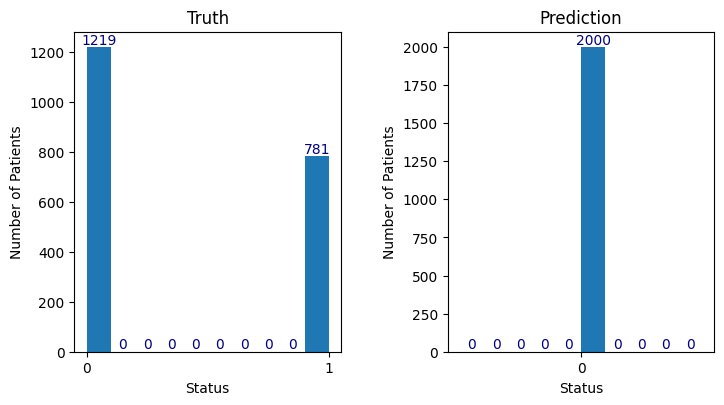

In [16]:
model_SVC = SVC(kernel='linear', C = 1.0).fit(X_train, y_train.ravel())
y_pred_SVC = model_SVC.predict(X_test)

plt.figure(figsize=(8,4))
ax = plt.subplot(1, 2, 1)
values, bins, bars = plt.hist(y_test)
ax.set_title("Truth", loc='center', wrap=True)
plt.xlabel("Status")
plt.ylabel("Number of Patients")
plt.bar_label(bars, fontsize=10, color='navy')

ax = plt.subplot(1, 2, 2)
values, bins, bars = plt.hist(y_pred_SVC)
ax.set_title("Prediction", loc='center', wrap=True)
plt.xlabel("Status")
plt.ylabel("Number of Patients")
plt.bar_label(bars, fontsize=10, color='navy')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

#show the plot
plt.show()

#### Two-Category Classification Model (LR)
Logistic regression is a parametric model.

Training the model is done suing the $fit$ function of the model included in sklearn. Testing the model is done using the $predict$ function of the model.

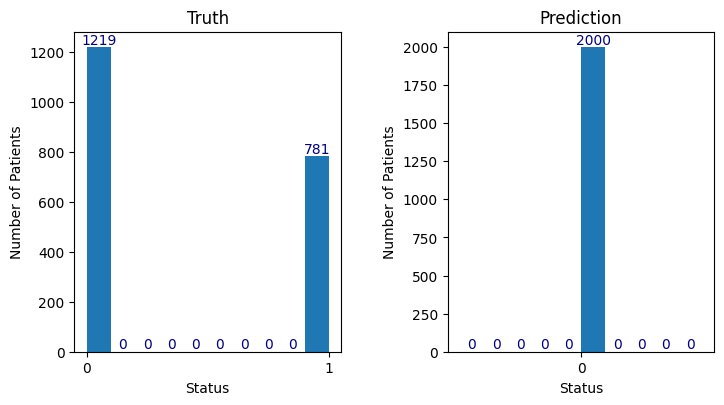

In [17]:
model_LR = lm.LogisticRegression().fit(X_train, y_train.ravel())
y_pred_LR = model_LR.predict(X_test)
plt.figure(figsize=(8,4))
ax = plt.subplot(1, 2, 1)
values, bins, bars = plt.hist(y_test)
ax.set_title("Truth", loc='center', wrap=True)
plt.xlabel("Status")
plt.ylabel("Number of Patients")
plt.bar_label(bars, fontsize=10, color='navy')

ax = plt.subplot(1, 2, 2)
values, bins, bars = plt.hist(y_pred_LR)
ax.set_title("Prediction", loc='center', wrap=True)
plt.xlabel("Status")
plt.ylabel("Number of Patients")
plt.bar_label(bars, fontsize=10, color='navy')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

#show the plot
plt.show()

#### Two-Category Classification Model (KNN)

K-nearst neighbors is a non-parametric model, but does include a hyperparameter of the number of neighbors upon which to base a classification.

Training the model is done suing the $fit$ function of the model included in sklearn. The number of neighbors was varied in odd numbers from 1 to 9. Testing the model is done using the $predict$ function of the model. The number of neighbors with the highest fraction of correct predictions was selected as the hyperparameter for this model.

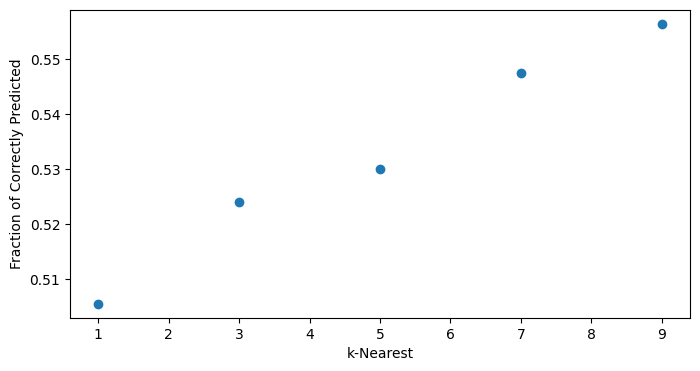

K of Max Correct Predictions: 9


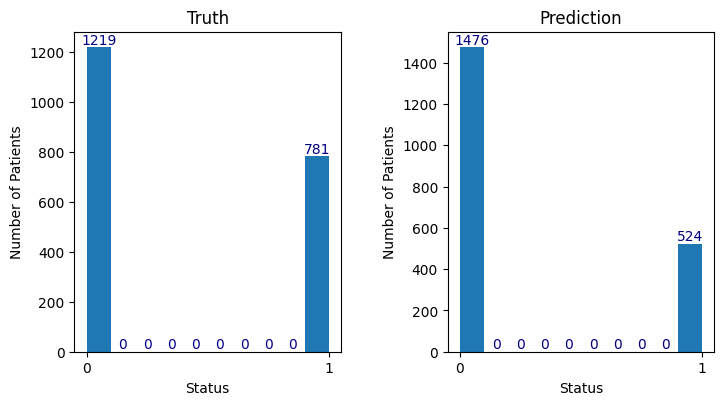

In [18]:
kNumber = np.zeros([5,1],dtype=np.uint8) 
num_correct = np.zeros([5,1]) 
indx = 0
M = len(y_test)

for k in range(1,10,2):
    model_KNN = knn.KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train.ravel())
    y_pred_KNN = model_KNN.predict(X_test)
    
    kNumber[indx] = k
    num_correct[indx] = np.count_nonzero(y_test.reshape(M,)==y_pred_KNN.reshape(M,))/M
    indx = indx + 1
    
plt.figure(figsize=(8,4))
plt.scatter(kNumber,num_correct)
ax.set_title("Number Correctly Predicted for k-values", loc='center', wrap=True)
plt.xlabel("k-Nearest")
plt.ylabel("Fraction of Correctly Predicted")
plt.show()

kMax = kNumber[np.argmax(num_correct)][0]
print("K of Max Correct Predictions:",kMax)
model_KNN = knn.KNeighborsClassifier(n_neighbors=kMax).fit(X_train, y_train.ravel())
y_pred_KNN = model_KNN.predict(X_test)
    
plt.figure(figsize=(8,4))
ax = plt.subplot(1, 2, 1)
values, bins, bars = plt.hist(y_test)
ax.set_title("Truth", loc='center', wrap=True)
plt.xlabel("Status")
plt.ylabel("Number of Patients")
plt.bar_label(bars, fontsize=10, color='navy')

ax = plt.subplot(1, 2, 2)
values, bins, bars = plt.hist(y_pred_KNN)
ax.set_title("Prediction", loc='center', wrap=True)
plt.xlabel("Status")
plt.ylabel("Number of Patients")
plt.bar_label(bars, fontsize=10, color='navy')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

#show the plot
plt.show()

#### Final Model Selection

Due to either feature selection or hyperparameter tuning (or likely a combination of both) only the KNN model gives any solution other than all data is classified as non-cancerous (category 0).

In [19]:
model = model_KNN
y_pred = model.predict(X_test)

## Model Results

We are able to see how well this final model does on classification of previously unkown data using a confusion matrix. This analyisis shows the correct predictions (along the diagonal), and the incorrect predictions (off-diagonal). We see that despite an overall number of predictions in each category that is close to truth, there are a number of mis-diagnosed classifications.

[[904 315]
 [572 209]]
TN: 904 TP: 209 FN: 572 FP: 315


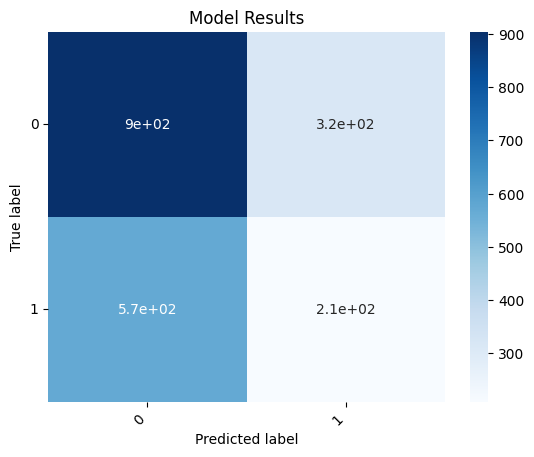

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
TN = conf_matrix[0][0]
TP = conf_matrix[1][1]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
print("TN:",TN,"TP:",TP,"FN:",FN,"FP:",FP)

plt.figure()
heatmap = sns.heatmap(conf_matrix, annot=True, cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Model Results')
plt.show()  

#### Performance Metrics: Accuracy, Specificity, Fallout
Three measures were used to determine the correctness of the model. These are accuracy, precision, and recall. As the detection of the 'cancerous' images is the positive category and the one we are most interested in, metrics that deal with classification or misclassification of this type are the more important. It is desired to have a large precision, large specificity, and large recall. Specificity and fall-out are less important to a person's physical health, but still impotant for the mental heath (i.e. not causing inaccurate "cancer scares") of the patient.

Accuracy: the proportion of true results among the total number of cases examined. $(TP+TN)/(TP+FP+TN+FN)$

Precision: used to calculate how much proportion of all data that was predicted positive was true positive. $TP/(TP+FP)$

Recall: used to calculate how much proportion of true positives is correctly classified as positive. $TP/(TP+FN)$

Specificity: used to calculate how much proportion of true negatives is correctly classified as negative. $TN/(TN+FP)$

Fall-out: used to calculate how much proportion of true negatives is incorrectly classified as positive. $FP/(FP+TN)$

In [21]:
Acc = round((TP+TN)/(TP+FP+TN+FN),3)
Prec =  round(TP/(TP+FP),3)
Recall =  round(TP/(TP+FN),3)
Specif = round(TN/(TN+FP),3)
Fallout = round(FP/(FP+TN),3)
#print("Accuracy:",Acc,"Precision:",Prec,"Recall:",Recall,"Specificity",Specif,"Fallout:",Fallout)
print("Accuracy:",Acc,"Precision",Prec,"Recall:",Recall)

Accuracy: 0.556 Precision 0.399 Recall: 0.268


## Conclusions

We see that currently, none of the models above - even the final model - are very good at correctly classifying medical images. Acccuracy of the model is barely above half, and precision and recall are even lower.

In [22]:
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [23]:
def load_testdata_by_names(df):
    """ This functions loads a specified list of images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    N = len(df)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = None
    #read images one by one
    for index, row in df.iterrows():
        X[i] = cv2.imread(f'../input/histopathologic-cancer-detection/test/{row.id}.tif')
          
    return X,y

submission_data, _ = load_testdata_by_names(df=submission)
clean_submission_data = clean_data(submission_data)
submission_features = extract_features(N=len(clean_submission_data),df=clean_submission_data)
submission.label = model.predict(submission_features)
submission.head()

(57458, 5)


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [24]:
submission.to_csv('submission.csv', header = True, index = False)

### Deliverables

1. Git Repository: https://github.com/smrhoades/cspb3202

References:
1. Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection
2. AMIRTAVAKKOLI13. (2024). https://www.kaggle.com/code/amirtavakkoli13/histopathologic-cancer-detection
3. PABLO GÓMEZ. (2019). https://www.kaggle.com/code/gomezp/training-vs-test-images
4. PABLO GÓMEZ (2018). https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93